In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    make_scorer,
    mean_squared_log_error,
)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
import cpi

In [26]:
data_df = pd.read_csv("train_full.csv")

In [27]:
data_df = data_df[
    [
        "budget",
        "popularity",
        "runtime",
        "vote_average",
        "vote_count",
        "release_date",
        "revenue",
    ]
]

In [28]:
# Realease date
data_df["release_date"] = pd.to_datetime(data_df["release_date"])
data_df["release_year"] = data_df["release_date"].dt.year

data_df["cpi"] = data_df["release_date"].apply(lambda x: cpi.get(x.year))
data_df = data_df.drop(columns=["release_date"])

In [29]:
print(data_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3969 entries, 0 to 3968
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   budget        3969 non-null   float64
 1   popularity    3969 non-null   float64
 2   runtime       3969 non-null   float64
 3   vote_average  3969 non-null   float64
 4   vote_count    3969 non-null   float64
 5   revenue       3969 non-null   float64
 6   release_year  3969 non-null   int32  
 7   cpi           3969 non-null   float64
dtypes: float64(7), int32(1)
memory usage: 232.7 KB
None


In [30]:
train, test = train_test_split(data_df, test_size=0.2, random_state=42)

In [31]:
pipeline = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(),
)
pipeline.fit(train.drop(columns=["revenue"]), train["revenue"])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor', RandomForestRegressor())])

In [32]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)
print("R2:", pipeline.score(test.drop(columns=["revenue"]), test["revenue"]))
print("RMSLE:", rmsle_scorer(pipeline, test.drop(columns=["revenue"]), test["revenue"]))

R2: 0.811447739568661
RMSLE: -2.005780723436006


In [33]:
# Rank movie predictions by error
test["predicted"] = pipeline.predict(test.drop(columns=["revenue"]))
test["error"] = abs(test["predicted"] - test["revenue"])
test["error_rank"] = test["error"].rank(ascending=False)
test.sort_values("error_rank", inplace=True)
test.head(10)

,budget,popularity,runtime,vote_average,vote_count,revenue,release_year,cpi,predicted,error,error_rank
937,22000000.0,72.773,127.0,7.206,5167.0,505000000.0,1990,130.700,1.536712e+08,3.513288e+08,1.0
2174,7000000.0,77.546,124.0,7.700,9689.0,470653000.0,1975,53.800,1.780614e+08,2.925916e+08,2.0
291,103400000.0,42.449,95.0,7.300,529.0,322000000.0,1946,19.500,7.075044e+07,2.512496e+08,3.0
2468,93000000.0,177.017,179.0,8.406,23634.0,871368364.0,2001,177.100,6.537943e+08,2.175740e+08,4.0
3511,80000000.0,105.830,91.0,6.691,9186.0,660998756.0,2006,201.600,4.657977e+08,1.952010e+08,5.0
2740,4400000.0,48.240,117.0,6.757,2482.0,245700832.0,1994,148.200,5.212465e+07,1.935762e+08,6.0
1702,50000000.0,58.932,118.0,7.261,7892.0,145079584.0,2011,224.939,3.347026e+08,1.896230e+08,7.0
1732,42000000.0,63.974,124.0,7.263,5630.0,363889678.0,1999,166.600,1.760498e+08,1.878399e+08,8.0
3826,17000000.0,48.541,99.0,6.877,3815.0,270000000.0,1982,96.500,8.445456e+07,1.855454e+08,9.0
274,150000000.0,17.954,143.0,6.788,10600.0,709700000.0,2007,207.342,5.278224e+08,1.818776e+08,10.0


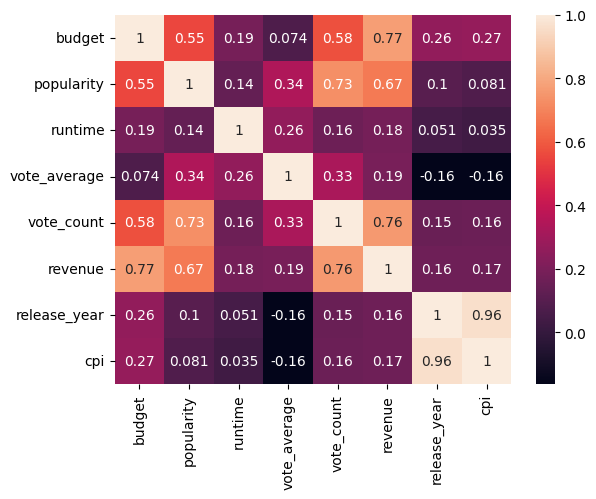

In [34]:
# Print correlation matrix
corr = data_df.corr()
sns.heatmap(corr, annot=True)
plt.show()

In [35]:
# Print the 10 most important features
feature_importances = pd.DataFrame(
    pipeline.steps[1][1].feature_importances_,
    index=train.drop(columns=["revenue"]).columns,
    columns=["importance"],
).sort_values("importance", ascending=False)
print(feature_importances.head(10))

              importance
vote_count      0.458814
budget          0.370653
popularity      0.068143
runtime         0.033433
vote_average    0.025160
release_year    0.022993
cpi             0.020805


In [36]:
# Make predictions for Kaggle

 